# New York CITY BIKE - Data Analysis and Trip Duration Prediction (part 2)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
from google.cloud import bigquery
from google.colab import auth

#@title Provide Google Credentials to Colab Runtime
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
#@title Enter Google Cloud/BigQuery Project ID
project_id = 'city-bike-trips-435211' #@param{type:"string"}

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [4]:
#@title Retrieving trips data
%%bigquery trips --project {project_id}
WITH weather AS(
  SELECT
        DATE(
        CAST(year AS INT64),
        CAST(mo AS INT64),
        CAST(da AS INT64)
        ) AS date,
        temp,
        max AS max_temp,
        min AS min_temp,
        CASE
          WHEN wdsp='999.9' THEN null ELSE wdsp
        END AS wind_speed,
        CASE
          WHEN visib>100 THEN null ELSE visib
        END AS visibility,
        prcp AS precipitation,
  FROM `bigquery-public-data.noaa_gsod.*`
  WHERE wban like '94728'
        AND year>='2013'
        AND year<='2019'
  ORDER BY date
),
trips_records AS(
  SELECT
    DATE(starttime) AS date,
    CAST(EXTRACT(DAYOFWEEK FROM  starttime) AS INT64) AS day_of_week,
    CAST(EXTRACT(MONTH FROM  starttime) AS INT64) AS month,
    CAST(EXTRACT(YEAR FROM  starttime) AS INT64) AS year,
    COUNT(starttime) AS number_of_trips,
    start_station_name
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE starttime IS NOT NULL AND stoptime IS NOT NULL
  GROUP BY date, day_of_week, month, year, start_station_name
)

SELECT *
FROM trips_records
LEFT JOIN weather
  ON trips_records.date = weather.date

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
trips

,date,day_of_week,month,year,number_of_trips,start_station_name,date_1,temp,max_temp,min_temp,wind_speed,visibility,precipitation
0,2016-08-16,3,8,2016,44,West End Ave & W 94 St,2016-08-16,82.5,91.9,77.0,2.6,8.1,0.00
1,2017-06-19,2,6,2017,30,Pike St & Monroe St,2017-06-19,79.3,87.1,69.8,3.4,8.6,0.00
2,2018-01-09,3,1,2018,46,1 Ave & E 78 St,2018-01-09,35.6,44.1,17.1,6.4,9.5,0.01
3,2018-05-17,5,5,2018,109,E 58 St & 1 Ave,2018-05-17,61.2,71.1,55.4,1.3,4.2,0.54
4,2013-07-19,6,7,2013,94,W 42 St & 8 Ave,2013-07-19,89.1,96.1,82.9,3.6,6.7,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
731656,2018-01-03,4,1,2018,7,Putnam Ave & Nostrand Ave,2018-01-03,21.6,30.0,12.9,3.5,10.0,0.00
731657,2015-02-03,3,2,2015,3,S 4 St & Wythe Ave,2015-02-03,18.1,34.0,12.9,7.2,8.9,0.34
731658,2015-02-28,7,2,2015,2,Monroe St & Classon Ave,2015-02-28,21.5,30.0,12.9,3.6,10.0,0.00
731659,2015-01-31,7,1,2015,1,Macon St & Nostrand Ave,2015-01-31,19.6,37.9,12.9,11.8,10.0,0.01


In [ ]:
trips.describe()

,day_of_week,month,year,number_of_trips,temp,max_temp,min_temp,wind_speed,visibility,precipitation,start_station_label,season_encoded,weekend_label
count,701511.0,701511.0,701511.0,701511.0,701511.000000,701511.000000,701511.000000,701511.000000,701511.000000,701511.000000,701511.000000,701511.000000,701511.000000
mean,3.997672,6.45908,2015.789092,62.917576,0.600153,0.603196,0.583951,0.312121,0.869117,0.028376,483.220823,1.464346,0.288445
std,2.005863,3.375916,1.549328,53.576416,0.211635,0.222839,0.204664,0.161177,0.193409,0.073897,257.931074,1.092971,0.453039
min,1.0,1.0,2013.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,4.0,2015.0,20.0,0.436740,0.427329,0.429594,0.195122,0.807692,0.000000,267.000000,1.000000,0.000000
50%,4.0,6.0,2016.0,47.0,0.621655,0.626087,0.594272,0.292683,0.974359,0.000000,481.000000,1.000000,0.000000
75%,6.0,9.0,2017.0,94.0,0.793187,0.800000,0.774463,0.406504,1.000000,0.015453,711.000000,2.000000,1.000000
max,7.0,12.0,2018.0,226.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,916.000000,3.000000,1.000000


In [ ]:
trips.isnull().sum()

,0
date,0
day_of_week,0
month,0
year,0
number_of_trips,0
start_station_name,0
date_1,60230
temp,60230
max_temp,60230
min_temp,60230


In [5]:
trips['wind_speed'] = trips['wind_speed'].astype(float)
wind_speed_mean = trips.groupby(['year', 'month'])['wind_speed'].transform('mean')

# Fill missing wind speed values with the monthly mean
trips['wind_speed'].fillna(wind_speed_mean, inplace=True)

visibility_mean = trips.groupby(['year', 'month'])['visibility'].transform('mean')
trips['visibility'].fillna(trips['visibility'].mean(), inplace=True)

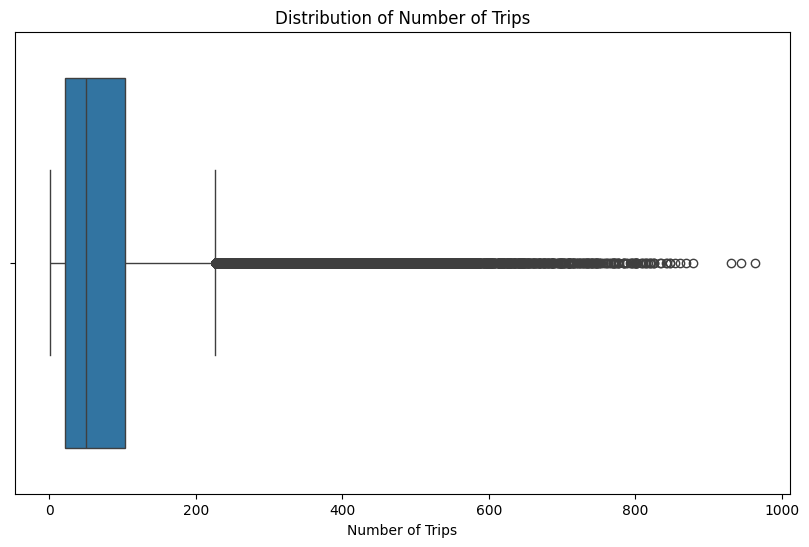

In [ ]:
#@title Distribution of number of trips with boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(x=trips['number_of_trips'])
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.show()


In [6]:
#@title Removing outliers of number of trips

# Calculate the IQR
Q1 = trips['number_of_trips'].quantile(0.25)
Q3 = trips['number_of_trips'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
trips = trips[(trips['number_of_trips'] >= lower_bound) & (trips['number_of_trips'] <= upper_bound)]

# You can now use trips_no_outliers for further analysis or modeling


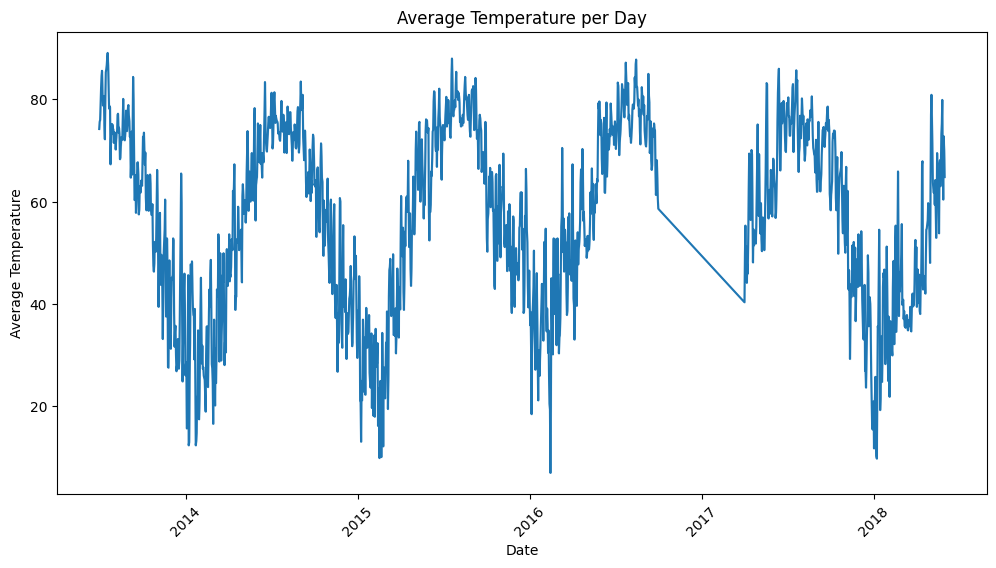

In [ ]:
# prompt: line plot with averege temp per day

plt.figure(figsize=(18, 6))
sns.lineplot(x='date', y='temp', data=trips)
plt.title('Average Temperature per Day')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.xticks(rotation=45)
plt.show()


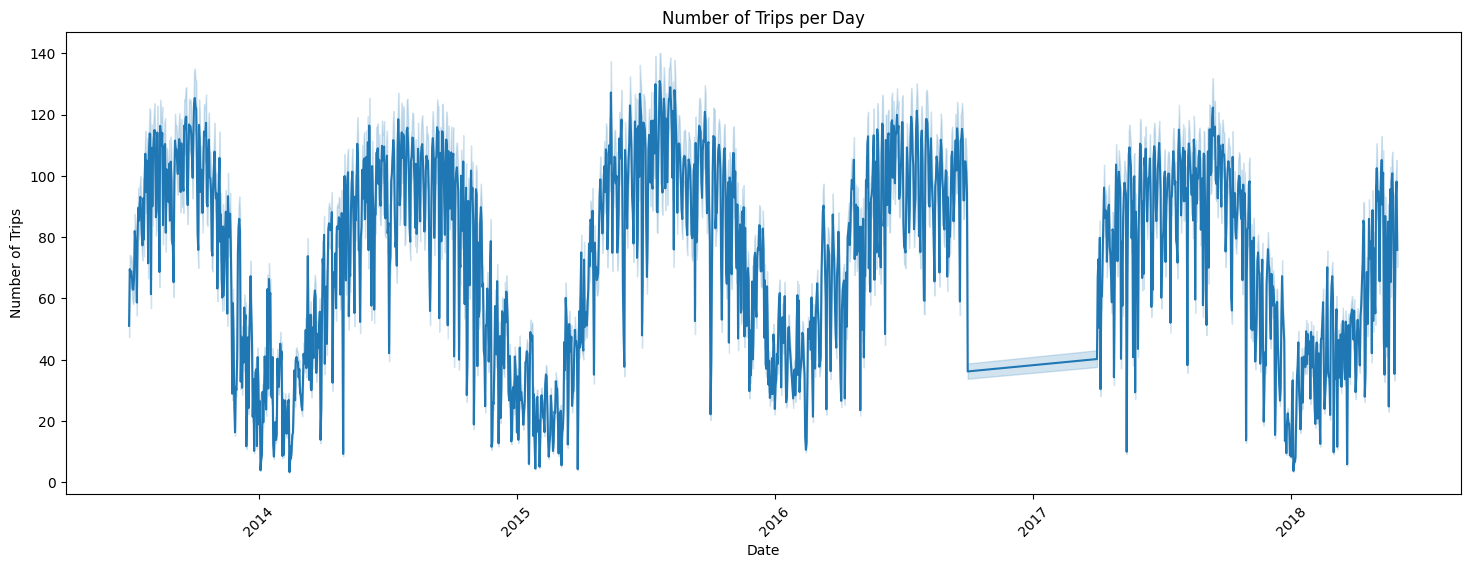

In [ ]:
# prompt: number of trips per date lineplot

plt.figure(figsize=(18, 6))
sns.lineplot(x='date', y='number_of_trips', data=trips)
plt.title('Number of Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()


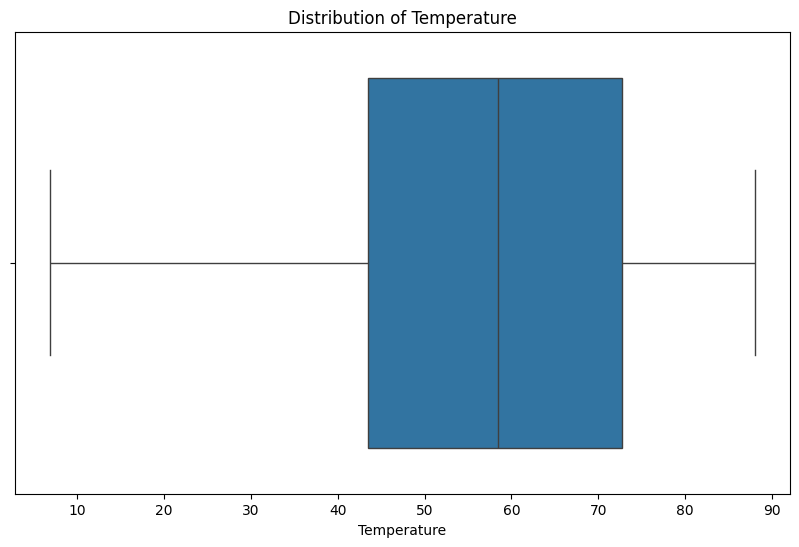

In [ ]:
# prompt: boxplot with temp distribution

plt.figure(figsize=(10, 6))
sns.boxplot(x=trips['temp'])
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')
plt.show()


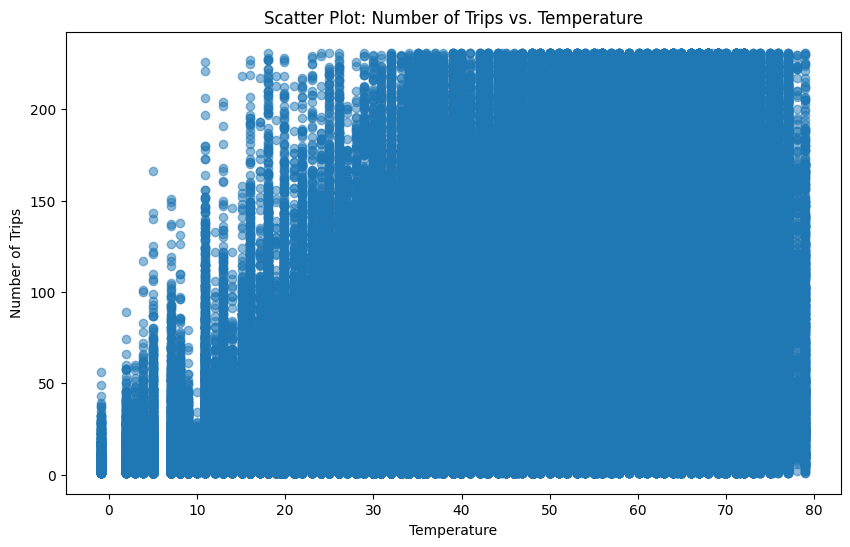

In [ ]:
#@title Number of Trips VS Temperature
plt.figure(figsize=(10, 6))
plt.scatter(trips['min_temp'], trips['number_of_trips'], alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Number of Trips')
plt.title('Scatter Plot: Number of Trips vs. Temperature')
plt.show()


In [7]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder object
le = LabelEncoder()

# Apply to start and end station names
trips['start_station_label'] = le.fit_transform(trips['start_station_name'])

In [8]:
# Function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Create a 'season' column
trips['season'] = trips['month'].apply(get_season)

# Convert the 'season' column to numerical values using label encoding
trips['season_encoded'] = trips['season'].astype('category').cat.codes

In [9]:
trips.drop(columns=['start_station_name', 'date', 'date_1', 'season'], inplace=True)

In [10]:
trips['weekend_label'] = trips['day_of_week'].apply(lambda x: 1 if x==7 or x==1 else 0)

In [11]:
min_max_scaler = MinMaxScaler()
trips[['temp', 'max_temp', 'min_temp',
       'wind_speed', 'visibility', 'precipitation']] = min_max_scaler.fit_transform(
       trips[['temp', 'max_temp', 'min_temp',
              'wind_speed', 'visibility', 'precipitation']])

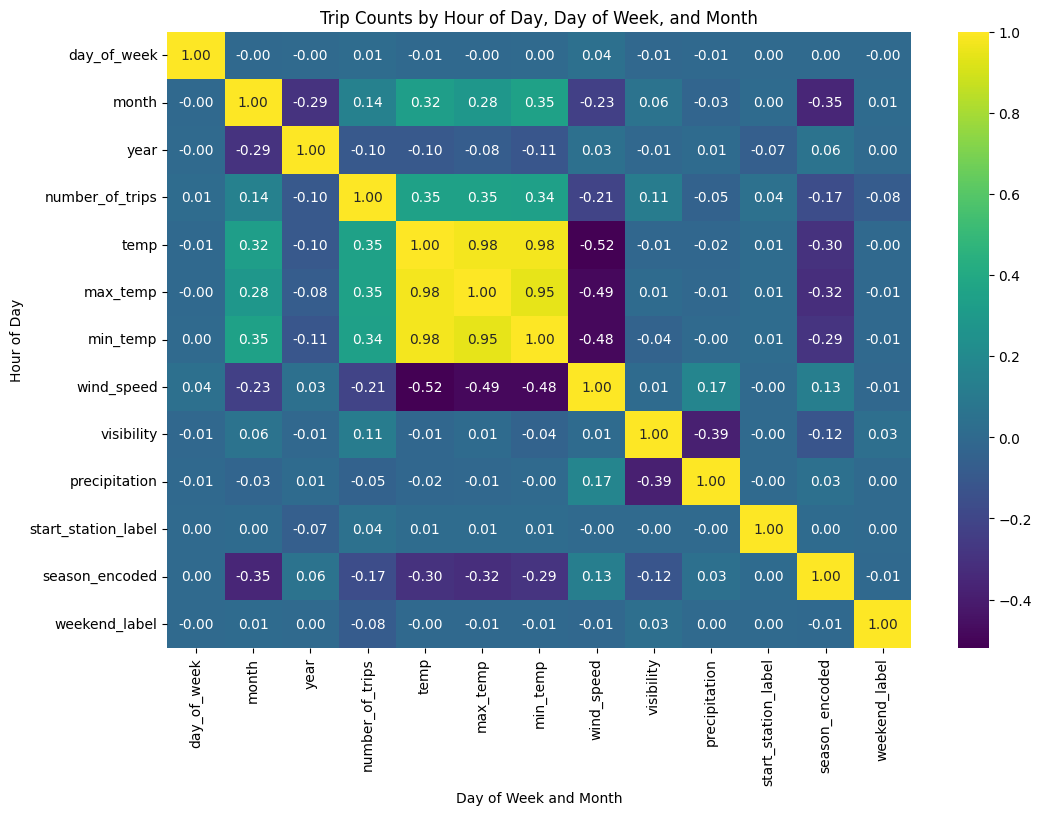

In [ ]:
# Creating the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(trips.corr(), cmap='viridis', annot=True, fmt='.2f')
plt.title('Trip Counts by Hour of Day, Day of Week, and Month')
plt.xlabel('Day of Week and Month')
plt.ylabel('Hour of Day')
plt.show()

In [17]:
# Split the data into training and testing sets
X = trips.drop(columns=['number_of_trips'])
y = trips['number_of_trips']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42)
random_forest_model.fit(X_train, y_train)

r2 = r2_score(y_test, random_forest_model.predict(X_test))
mse = mean_squared_error(y_test, random_forest_model.predict(X_test))
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 328.5478276309132
R-squared: 0.8860186623783298
